Load data.

In [1]:
### LINES TO IMPORT THE DECONFOUNDER PACKAGE IN THE PARENT FOLDER ###
import os
import sys
sys.path.append("..")
### IMPORTS
import matplotlib.pyplot as plt
import numpy as np
from numpy.polynomial.polynomial import polyfit
import pandas as pd
import scipy.stats as st
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import time

# Load data
df = pd.read_csv("../data/criteo-uplift-v2.1.csv")
df = df.sample(frac=1, random_state=42)

Test the treatment was randomly assigned (according to the F-statistic, it appears it was not).

In [9]:
import statsmodels.api as sm

all_features = df.columns.values[:12].tolist()
X = sm.add_constant(df[all_features])
y = df.treatment
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

C:\Users\ferlo\Anaconda3\envs\deconfounder\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


                            OLS Regression Results                            
Dep. Variable:              treatment   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     428.5
Date:                Wed, 17 Feb 2021   Prob (F-statistic):               0.00
Time:                        22:44:17   Log-Likelihood:            -5.4372e+06
No. Observations:            13979592   AIC:                         1.087e+07
Df Residuals:                13979579   BIC:                         1.087e+07
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9932      0.024     41.992      0.0

Data according to treatment.

In [12]:
treated = df.treatment == 1
X_tr = df.loc[treated, all_features]
y_tr = df.conversion[treated]
X_un = df.loc[~treated, all_features]
y_un = df.conversion[~treated]

Train, tune, and make out of sample predictions for the untreated.

In [89]:
from sklearn.tree import DecisionTreeClassifier

tuned_parameters = [{'min_samples_leaf': [4000, 8000, 16000, 32000]}]
grid_tree = GridSearchCV(DecisionTreeClassifier(random_state=42), tuned_parameters, scoring='roc_auc', cv=5, verbose=10)
grid_tree.fit(X_un, y_un)
print("Best parameters set found on development set:")
print(grid_tree.best_params_)
untreated_tree = grid_tree.best_estimator_

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] min_samples_leaf=2000 ...........................................
[CV] ............... min_samples_leaf=2000, score=0.930, total=  22.0s
[CV] min_samples_leaf=2000 ...........................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   21.9s remaining:    0.0s


[CV] ............... min_samples_leaf=2000, score=0.943, total=  17.2s
[CV] min_samples_leaf=2000 ...........................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   39.1s remaining:    0.0s


[CV] ............... min_samples_leaf=2000, score=0.938, total=  14.8s
[CV] min_samples_leaf=2000 ...........................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   53.9s remaining:    0.0s


[CV] ............... min_samples_leaf=2000, score=0.944, total=  16.6s
[CV] min_samples_leaf=2000 ...........................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  1.2min remaining:    0.0s


[CV] ............... min_samples_leaf=2000, score=0.933, total=  17.0s
[CV] min_samples_leaf=4000 ...........................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.5min remaining:    0.0s


[CV] ............... min_samples_leaf=4000, score=0.945, total=  16.0s
[CV] min_samples_leaf=4000 ...........................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  1.7min remaining:    0.0s


[CV] ............... min_samples_leaf=4000, score=0.952, total=  13.7s
[CV] min_samples_leaf=4000 ...........................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  2.0min remaining:    0.0s


[CV] ............... min_samples_leaf=4000, score=0.947, total=  14.0s
[CV] min_samples_leaf=4000 ...........................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  2.2min remaining:    0.0s


[CV] ............... min_samples_leaf=4000, score=0.950, total=  14.5s
[CV] min_samples_leaf=4000 ...........................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  2.4min remaining:    0.0s


[CV] ............... min_samples_leaf=4000, score=0.945, total=  14.0s
[CV] min_samples_leaf=8000 ...........................................
[CV] ............... min_samples_leaf=8000, score=0.951, total=  12.7s
[CV] min_samples_leaf=8000 ...........................................
[CV] ............... min_samples_leaf=8000, score=0.957, total=  12.8s
[CV] min_samples_leaf=8000 ...........................................
[CV] ............... min_samples_leaf=8000, score=0.949, total=  12.3s
[CV] min_samples_leaf=8000 ...........................................
[CV] ............... min_samples_leaf=8000, score=0.955, total=  14.5s
[CV] min_samples_leaf=8000 ...........................................
[CV] ............... min_samples_leaf=8000, score=0.949, total=  13.2s
[CV] min_samples_leaf=16000 ..........................................
[CV] .............. min_samples_leaf=16000, score=0.952, total=  11.4s
[CV] min_samples_leaf=16000 ..........................................
[CV] .

[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:  5.4min finished


Best parameters set found on development set:
{'min_samples_leaf': 16000}


Train, tune, and make out of sample predictions for the treated.

In [90]:
tuned_parameters = [{'min_samples_leaf': [4000, 8000, 16000, 32000]}]
grid_tree = GridSearchCV(DecisionTreeClassifier(random_state=42), tuned_parameters, scoring='roc_auc', cv=5, verbose=10)
grid_tree.fit(X_tr, y_tr)
print("Best parameters set found on development set:")
print(grid_tree.best_params_)
treated_tree = grid_tree.best_estimator_

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] min_samples_leaf=4000 ...........................................
[CV] ............... min_samples_leaf=4000, score=0.951, total= 2.0min
[CV] min_samples_leaf=4000 ...........................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.0min remaining:    0.0s


[CV] ............... min_samples_leaf=4000, score=0.949, total= 2.0min
[CV] min_samples_leaf=4000 ...........................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  4.0min remaining:    0.0s


[CV] ............... min_samples_leaf=4000, score=0.949, total= 2.3min
[CV] min_samples_leaf=4000 ...........................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  6.4min remaining:    0.0s


[CV] ............... min_samples_leaf=4000, score=0.952, total= 2.3min
[CV] min_samples_leaf=4000 ...........................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  8.7min remaining:    0.0s


[CV] ............... min_samples_leaf=4000, score=0.950, total= 2.1min
[CV] min_samples_leaf=8000 ...........................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 10.8min remaining:    0.0s


[CV] ............... min_samples_leaf=8000, score=0.954, total= 2.1min
[CV] min_samples_leaf=8000 ...........................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 12.9min remaining:    0.0s


[CV] ............... min_samples_leaf=8000, score=0.952, total= 2.1min
[CV] min_samples_leaf=8000 ...........................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 15.0min remaining:    0.0s


[CV] ............... min_samples_leaf=8000, score=0.953, total= 2.4min
[CV] min_samples_leaf=8000 ...........................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 17.3min remaining:    0.0s


[CV] ............... min_samples_leaf=8000, score=0.955, total= 2.4min
[CV] min_samples_leaf=8000 ...........................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 19.7min remaining:    0.0s


[CV] ............... min_samples_leaf=8000, score=0.953, total= 2.0min
[CV] min_samples_leaf=16000 ..........................................
[CV] .............. min_samples_leaf=16000, score=0.955, total= 1.8min
[CV] min_samples_leaf=16000 ..........................................
[CV] .............. min_samples_leaf=16000, score=0.954, total= 1.8min
[CV] min_samples_leaf=16000 ..........................................
[CV] .............. min_samples_leaf=16000, score=0.955, total= 2.1min
[CV] min_samples_leaf=16000 ..........................................
[CV] .............. min_samples_leaf=16000, score=0.957, total= 2.0min
[CV] min_samples_leaf=16000 ..........................................
[CV] .............. min_samples_leaf=16000, score=0.954, total= 1.9min
[CV] min_samples_leaf=32000 ..........................................
[CV] .............. min_samples_leaf=32000, score=0.955, total= 1.7min
[CV] min_samples_leaf=32000 ..........................................
[CV] .

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed: 40.2min finished


Best parameters set found on development set:
{'min_samples_leaf': 16000}


Look at relationship between scores.

SpearmanrResult(correlation=-0.03295036929947584, pvalue=0.46224924756764496)


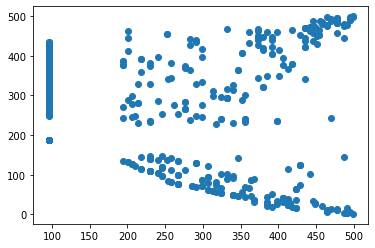

In [91]:
from scipy import stats

X_sample = X_un.sample(500, random_state=42)
un_pred = untreated_tree.predict_proba(X_sample)[:,1] 
tr_pred = treated_tree.predict_proba(X_sample)[:,1]
print(stats.spearmanr(un_pred, tr_pred-un_pred))
plt.scatter(pd.DataFrame(un_pred).rank()[0], pd.DataFrame(tr_pred-un_pred).rank()[0])

* Build both models using cross-validation to make out of sample predictions
* Build uplift curve for both approaches
* Uplift curve: cumsum sorted by treated - cumsum sorted by untreated

Get out of sample predictions.

In [125]:
from sklearn.model_selection import cross_val_predict

pred_un = cross_val_predict(untreated_tree, X_un, y_un, cv=5, method='predict_proba', verbose=10)[:, 1]
pred_tr = cross_val_predict(treated_tree, X_tr, y_tr, cv=5, method='predict_proba', verbose=10)[:, 1]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  5.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  7.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  9.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  9.5min finished


Compare performance of the approaches.

In [127]:
# Outcome model
pred_un_out = pred_un
pred_tr_out = untreated_tree.predict_proba(X_tr)[:, 1]
curve_un_out = y_un.iloc[np.argsort(-pred_un_out)].cumsum() / y_un.count()
curve_tr_out = y_tr.iloc[np.argsort(-pred_tr_out)].cumsum() / y_tr.count()
curve_out = curve_tr_out.quantile(np.arange(101) * 0.01) - curve_un_out.quantile(np.arange(101) * 0.01)
curve_out = curve_out / y_un.mean()

# Uplift model
pred_un_up = treated_tree.predict_proba(X_un)[:, 1] - pred_un
pred_tr_up = pred_tr - untreated_tree.predict_proba(X_tr)[:, 1]
curve_un_up = y_un.iloc[np.argsort(-pred_un_up)].cumsum() / y_un.count()
curve_tr_up = y_tr.iloc[np.argsort(-pred_tr_up)].cumsum() / y_tr.count()
curve_up = curve_tr_up.quantile(np.arange(101) * 0.01) - curve_un_up.quantile(np.arange(101) * 0.01)
curve_up = curve_up / y_un.mean()

Compare uplift curves of both models.

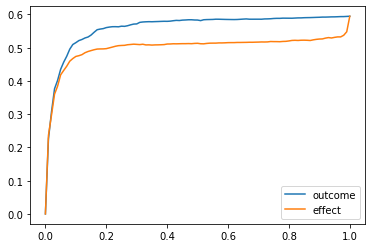

In [128]:
plt.plot(curve_out, label="outcome")
plt.plot(curve_up, label="effect")
plt.legend()

Compare with Causal Tree.

In [98]:
from deconfounder.causal_tree import CausalTree

X = df[all_features + ['treatment']].rename(columns={"treatment":"treated"})
y = df.conversion
tuned_parameters = [{'min_samples_leaf': [16000]}]
grid_tree = GridSearchCV(CausalTree(random_state=42), tuned_parameters, cv=5, verbose=10)
grid_tree.fit(X, y)
print("Best parameters set found on development set:")
print(grid_tree.best_params_)
causal_tree = grid_tree.best_estimator_

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] min_samples_leaf=16000 ..........................................
[CV] .............. min_samples_leaf=16000, score=0.000, total= 3.4min
[CV] min_samples_leaf=16000 ..........................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.4min remaining:    0.0s


[CV] .............. min_samples_leaf=16000, score=0.000, total= 3.2min
[CV] min_samples_leaf=16000 ..........................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  6.6min remaining:    0.0s


[CV] .............. min_samples_leaf=16000, score=0.000, total= 3.6min


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 10.2min remaining:    0.0s


[CV] min_samples_leaf=16000 ..........................................
[CV] .............. min_samples_leaf=16000, score=0.000, total= 4.3min
[CV] min_samples_leaf=16000 ..........................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 14.5min remaining:    0.0s


[CV] .............. min_samples_leaf=16000, score=0.000, total= 2.6min


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 17.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 17.1min finished


Best parameters set found on development set:
{'min_samples_leaf': 16000}


SpearmanrResult(correlation=0.22625543473818818, pvalue=3.1705832837712594e-07)


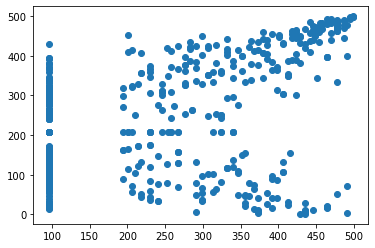

In [99]:
X_sample = X_un.sample(500, random_state=42)
un_pred = untreated_tree.predict_proba(X_sample)[:,1] 
up_pred = causal_tree.predict(X_sample)
print(stats.spearmanr(un_pred, up_pred))
plt.scatter(pd.DataFrame(un_pred).rank()[0], pd.DataFrame(tr_pred-up_pred).rank()[0])

Get out of sample predictions and uplift curve.

In [129]:
pred_up = cross_val_predict(causal_tree, X, y, cv=5, method='predict', verbose=10)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  6.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 10.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 14.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 18.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 21.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 21.4min finished


In [130]:
# Uplift model (with causal tree)
pred_un_up2 = pred_up[~treated]
pred_tr_up2 = pred_up[treated]
curve_un_up2 = y_un.iloc[np.argsort(-pred_un_up2)].cumsum() / y_un.count()
curve_tr_up2 = y_tr.iloc[np.argsort(-pred_tr_up2)].cumsum() / y_tr.count()
curve_up2 = curve_tr_up2.quantile(np.arange(101) * 0.01) - curve_un_up2.quantile(np.arange(101) * 0.01)
curve_up2 = curve_up2 / y_un.mean()

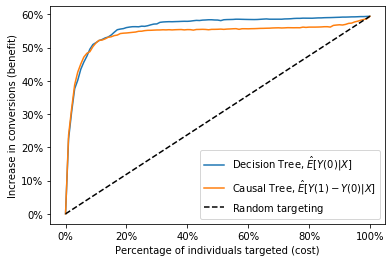

In [170]:
import matplotlib.ticker as mtick

ax = plt.plot(range(0, 101), curve_out*100, label=r"Decision Tree, $\hat{E}[Y(0)|X]$")[0]
#plt.plot(curve_up, label="naive uplift")
plt.plot(range(0, 101), curve_up2*100, label="Causal Tree, $\hat{E}[Y(1) - Y(0)|X]$")
plt.plot([0, 100], [0, curve_out.iloc[-1]*100], '--', color='black', label=r"Random targeting $\;$")
plt.xlabel("Percentage of individuals targeted (cost)")
plt.ylabel("Increase in conversions (benefit)")
plt.legend()

ax.axes.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.axes.xaxis.set_major_formatter(mtick.PercentFormatter())
plt.savefig("uplift curves.png", dpi=300)